In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import json
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML
import pdfkit
from pdf2image import convert_from_bytes
import pyvips
import cv2 as cv
import re
from subprocess import run, PIPE
import glob
import itertools
import time
import cProfile
from clibrary import library
import multiprocessing
np.random.seed(1)

### Template Generator
Generate table with certain properties (borderless,boredered and so on). Results in a string representing the tabl3 in html. The required input is a pandas dataframe.
- borderless (no borders)
- bordered header (only header bordered)
- bordered header and bottom (only header and end bordered)
- bordered internal columns (only internal column bordered)
- bordered columns (columns bordered)
- bordered (grid table )

In [2]:
class TemplateGenerator:
    ''' remove top rule, mid rule , bottom rule'''
    def clean_template(self,template:str)->str:
        line = template.replace('style="text-align: right;"',"")
        return line
    
    ''' format the column names '''
    def format_columns(self,df)->List[str]:
        cols = list(df.columns)
        formated_cols = [''.join(['[',col,']']) for col in cols]
        return formated_cols
    
    ''' format column names to bold '''
    def format_template(self,template:str)->str:
        line = template.replace('class="dataframe"',"")
        return line
        
    ''' no borders'''
    def borderless(self,df)->str:
        template = df.to_html(index=False,border=0)
        template = self.clean_template(template)
        template = self.format_template(template)
        return template
    
    ''' no border except in header'''
    def bordered_header(self,df)->str:
        template = df.to_html(index=False,border=0)
        template = self.clean_template(template)
        template = self.format_template(template)
        template = template.replace("<th>",'<th style="border:thin solid black;">')
        return template
    
    ''' no border except in header and bottom'''
    def bordered_header_bottom(self,df)->str:
        template = self.bordered_header(df)
        lines = (template.split("\n"))
        style = '<tr style = "border-bottom: thin solid black;"'
        for i in range(len(lines)-1,-1,-1):
            if lines[i].find("<tr")!=-1:
                lines[i] = lines[i].replace("<tr",style)
                break;
        template = "\n".join(lines);
        template = template.replace("<table",'<table style="border-collapse:collapse"')
        return template
    
    ''' only internal columns bordered would essentialy be same as latex so no need '''
    def bordered_internal_columns(self,df)->str:
        template = self.bordered_header(df)
        t_style = '<table style="border-collapse:collapse; border-style: hidden;"'
        style = '<td style="border-left: thin solid black;border-right: thin solid black  "'
        template = template.replace("<td",style)
        template = template.replace('<table',t_style)
        return template
    
    ''' only columns bordered '''
    def bordered_columns(self,df)->str:
        template = self.bordered_header(df)
        style = '<td style="border: thin solid black;"'
        template = template.replace("<td",style)
        return template
    
    ''' partialy bordered'''
    def partialy_bordered(self,df)->str:
        template = self.bordered_header_bottom(df)
        style = '<td style="border-left: thin solid black; border-right: thin solid black;"'
        template = template.replace("<td",style)
        lines = template.split("\n")
        idx = []
        for i in range(len(lines)):
            line = lines[i]
            found = line.find("<tr")
            if found!=-1:
                idx.append(i)
        mid = len(idx)//2
        replaced = []
        for i in idx[2:mid]:
            temp = lines[i]
            temp = temp.replace('<tr','<tr style="border-bottom:thin solid black"')
            lines[i] = temp
        template = "\n".join(lines)
        return template
    
    ''' all borders '''
    def bordered(self,df)->str:
        template = df.to_html(index=False,border=1)
        template = self.clean_template(template)
        template = self.format_template(template)
        return template  

### Complex Template Generator
Generate a table with a table in one of its columns. Results string representing the tabular in latex. The required input is 2 pandas dataframes (inner and outer). Extends the Template Generator.
- Embedded (bordered outer table in which one of the columns contains a tables generate by template generator )

In [3]:
class ComplexTemplateGenerator(TemplateGenerator):
    ''' all borders for outer tables '''
    def bordered(self,df_c)->str:
        df = df_c.copy()
        r_index = np.random.randint(0,df.shape[0])
        c_index = np.random.randint(0,df.shape[1])
        index = c_index
        df.iat[r_index,c_index] = '*'
        template = df.to_html(index=False,border=1)
        template = self.clean_template(template)
        template = self.format_template(template)
        return template
    
    ''' format a complex(embedded) template '''
    def format_complex_template(self,outer_template:str,inner_template:str):
        lines = outer_template.split("\n")
        for i in range(len(lines)):
            line = lines[i]
            if line.find("*")!=-1:
                lines[i] = lines[i].replace("*",inner_template)
            
        template = "\n".join(lines)
        return template
    
    def embedded(self,df_outer,df_inner,f)->str:
        df_outer = df_outer.astype(str)
        df_inner = df_inner.astype(str)
        outer_str = self.bordered(df_outer)
        inner_str = f(df_inner)
        template = self.format_complex_template(outer_str,inner_str)
        return template

### Table Generator

Wraps a generated tabular around a table and adds a caption. Also draws borders for use later in making table mask. The expected input is a html format string coming from the template or complex template generator.

In [4]:
class TableGenerator:
    def __init__(self):
        self.transparent = ' bgcolor="white"'
        self.colour = ' bgcolor="red"'
        
    def outlined_table(self,template:str)->str:
        template = template.replace('<table',''.join(['<table',self.colour]))
        return template
        
    def outlined_tables(self,templates:List[str])->List[str]:
        tables = []
        for template in templates:
            table = self.outlined_table(template)
            tables.append(table)
        return tables
        
    def table(self,template:str)->str:
        template = template.replace('<table',''.join(['<table',self.transparent]))
        return template
    
    def tables(self,templates:List[str])->List[str]:
        tables = []
        for template in templates:
            table = self.table(template)
            tables.append(table)
        return tables
        

### Table Writer
Uses a default latex template and writes tables to it (Includes writing random text), which can later be converted to pdf.

In [5]:
class TableWriter:    
    def __init__(self):
        self.env = Environment(loader=FileSystemLoader('.'))
        self.template = self.env.get_template("templates/html/template.html")
        with open('templates/latex/config.json','r') as f:
            paragraphs = json.load(f)
        self.paragraphs = []
        for key in paragraphs:
            text = "\n".join(paragraphs[key])
            self.paragraphs.append(text)
            
    ''' just write a single table '''
    def write_single(self,table:str)->str:
        tables = [{"header":"Table 1",
                 "table": table,'text':self.paragraphs[0]}]
        template_vars = {"title" : "Sales Funnel Report - National",
                 "tables": tables,"close":self.paragraphs[-1]}
        html_out = self.template.render(template_vars)
        return html_out
    
    ''' write multiple tables '''
    def write(self,tables:List[str])->str:
        result = []
        for i in range(len(tables)):
            t = {"header":"Table "+str(i+1),"table":tables[i],'text':self.paragraphs[i]}
            result.append(t)
        template_vars = {"title" : "Sales Funnel Report - National",
                 "tables": result,"close":self.paragraphs[-1]}
        html_out = self.template.render(template_vars)
        return html_out

### Pdf Generator
Generate a pdf in bytes from a given latex string. 

In [42]:
class PdfGenerator:
    ''' returns pdf bytes '''
    def pdf(self,html_str:str)->bytes:
        pdf = pdfkit.from_string(html_str,False,options={'--quiet':'','--dpi':200})
        return pdf
    
    ''' return list of pdf bytes'''
    def pdfs(self,html_strs:List[str])->List[bytes]:
        pdfs = []
        for html_str in html_strs:
            pdf = self.pdf(html_str)
            pdfs.append(pdf)
        return pdfs

### Pdf 2 Imgs
Convert pdf to images, so we can convert to images and generate masks.

In [43]:
class PdfToImg:
    ''' pdf to img '''
    def pdf_to_img(self,pdf_bytes:bytes):
        img = convert_from_bytes(pdf_bytes,dpi=200)[0]
        return np.asarray(img,dtype=np.uint8)
    
    ''' pdfs to imgs '''
    def pdfs_to_imgs(self,pdfs:List[bytes]):
        pdf_imgs = []
        for pdf in pdfs:
            img_pdf = self.pdf_to_img(pdf)
            pdf_imgs.append(img_pdf)
        return pdf_imgs

### Transformer
Transform a given image , to try and mimic real world data of scanned images. The following transforms applicable
- Gaussian Blur $k$ (kernel size), $(k,k)$ 
- Scale $(sx,sy)$ 
- Rotate $\theta$

In [44]:
class Transformer:
    ''' blur (! later must investigate scan effect)'''
    def blur(self,img,kernel):
        sigma_x,sigma_y = 2,2
        blurred_img = cv.GaussianBlur(img,kernel,sigma_x,sigma_y)
        return blurred_img
    
    ''' rotate '''
    def rotate(self,img,theta:float,border=(255,255,255)):
        height, width = img.shape[:2]
        center = (width/2, height/2)
        rotate_matrix = cv.getRotationMatrix2D(center=center, angle=theta, scale=1)
        rotated_img = cv.warpAffine(src=img, M=rotate_matrix, dsize=(width, height),borderValue=border)
        return rotated_img
    
    ''' dirtify data by applying sequence of transformations'''
    def dirtify(self,img,k:int,s_x:int,s_y:int,theta:float,mask:bool):
        m,n = img.shape[:2]
        m,n = int(s_y*m),int(s_x*n)
        dim = (n,m)
        if not mask:
            x = self.blur(img,kernel=(k,k))
            y = cv.resize(x, dim, interpolation = cv.INTER_AREA)
            z = self.rotate(y,theta=theta)
        else:
            x = img
            y = cv.resize(x, dim, interpolation = cv.INTER_AREA)
            z = self.rotate(y,theta=theta,border=(0,0,0))
        return z

### Mask Generator
From the given pdf image generate table mask (label). This is done as follows.
- Compute absolute difference between raw pdf img and outlined img
- Apply adaptive thresholding to resulting image to obtain binary image
- Detect external contours in binary image and fill bounding box regions of contours

In [45]:
class PreProcessor:
    ''' grayscale the image '''
    def grayscale(self,img):
        grayscaled = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        return grayscaled
    
    ''' thresholding the image to a binary image '''
    def threshold(self,img,mode='adaptive'):
        if mode == 'adaptive':
            thresh = cv.adaptiveThreshold(img, 255, 1, 1, 11, 2)
            return thresh
        elif mode=='otsu':
            _,thresh = cv.threshold(img,128,255,cv.THRESH_BINARY |cv.THRESH_OTSU)
            return thresh

    ''' apply preprocessing steps ''' 
    def preprocess(self,img):
        grayscaled = self.grayscale(img)
        thresholded = self.threshold(grayscaled)
        return thresholded
    
class MaskGenerator:
    def __init__(self):
        self.preprocessor = PreProcessor()
       
    ''' fill region with specified contours '''
    def fill(self,shape,contours):
        filled_binary_mask = np.zeros(shape,dtype=np.uint8)
        bounding_rectangles = []
        for contour in contours:
            rect = cv.boundingRect(contour)
            x,y,w,h = rect
            filled_binary_mask[y:y+h,x:x+w] = 255
        return filled_binary_mask
            
    ''' fill the mask '''
    def fill_mask(self,mask):
        binary_mask = self.preprocessor.preprocess(mask)
        contours, _ = cv.findContours(binary_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        binary_mask = self.fill(binary_mask.shape,contours)
        return binary_mask
    
    ''' generate table mask taking difference of 2 imgs '''
    def mask(self,raw_img,outlined_img):
        x = raw_img
        y = outlined_img
        mask = abs(x-y)
        filled_mask = self.fill_mask(mask)
        return filled_mask
    
    def masks(self,raw_imgs,outlined_imgs):
        masks = []
        for i in range(len(raw_imgs)):
            x = raw_imgs[i]
            y = outlined_imgs[i]
            mask = self.mask(x,y)
            masks.append(mask)
        return masks

### Table Structure Generator
Generate xml like string representing table structure. This is done by making system call to latexml.

In [46]:
class StructureGenerator:
    def __init__(self):
        self.expression = '<table|<row|<cell|</cell>|</row>|</table>'
        self.regex = re.compile(self.expression)

    ''' markup representing table '''
    def structure(self,table:str)->str:
        html = (table)
        html = html.replace("<thead>\n","")
        html = html.replace("</thead>","")
        html = html.replace("<tr","<row")
        html = html.replace("/tr>","/row>")
        html = html.replace("<th","<td")
        html = html.replace("/th>","/td>")
        html = html.replace("<td","<cell")
        html = html.replace("/td>","/cell>")
        lines = re.findall(self.regex, html)
        lines = [lines[i]+'>' if lines[i].find(">")==-1 else lines[i] for i in range(len(lines))]
        structure = "\n".join(lines)
        return structure
    
    ''' generate table structures '''
    def structures(self,tables:List[str])->List[str]:
        structures = []
        for table in tables:
            structure = self.structure(table)
            structures.append(structure)
        return structures

### Metadata Generator
Metadata to be generated includes the following
- Number of tables - This is counted by counting the number of connected components in the mask (table regions should be disjoint regions of white pixels)
- Bounding boxes (of tables) - Generated by detecting external contours and returning nounding box
- XML strings of structure - latex string representation as arg yo structure generator

In [47]:
class MetadataGenerator(StructureGenerator):    
    ''' number of tables from table mask '''
    def number_of_tables(self,table_mask)->int:
        num,_ = cv.connectedComponents(table_mask)
        return num-1
    
    ''' sort the contours top to bottom '''
    def sort(self,contours):
        y_values = []
        for contour in contours:
            x,y,w,h = cv.boundingRect(contour)
            y_values.append(y)
        y_values = np.array(y_values)
        idx = np.argsort(y_values)
        sorted_contours = [contours[i] for i in idx]
        return sorted_contours
    
    ''' bounding boxes '''
    def bounding_boxes(self,table_mask):
        contours , _ = cv.findContours(table_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        sorted_contours = self.sort(contours)
        boxes = []
        for contour in sorted_contours:
            box = cv.boundingRect(contour)
            boxes.append(box)
        return boxes
    
    ''' generate metadata '''
    def metadata(self,table_mask,tables:List[str]):
        num_tables = self.number_of_tables(table_mask)
        bboxes = self.bounding_boxes(table_mask)
        bboxes_data = [bbox for bbox in bboxes]
        structures = self.structures(tables)
        result = {'no':num_tables,'bounding_boxes':bboxes_data,'structures':structures}
        return result

### Data Source
A pool of dataframes in which table data is pulled from. When data is needed for a table following happens
a call to sample with number of datafframes needed and mode (important for limits). The sample randomly selects dataframes and samples each randomly. Then shuffles dataframes order.

In [48]:
class DataSource:
    def __init__(self,path):
        self.data = self.load(path)
        self.N = len(self.data)
        self.MIN_ROWS = 2
        self.MIN_OUTER_ROWS = 4
        self.MAX_ROWS = 30
        self.MIN_COLS = 2
        self.MAX_COLS = 7
        self.MAX_COLS_INNER = 3
        self.MAX_COLS_OUTER = 3
        self.STATE = 42
        
    ''' prepare dataframe '''
    def prepare(self,df):
        df.columns = self.format_columns(df.columns)
        nan_value = float("NaN")
        df.replace("", "-", inplace=True)
        df.replace("NaN","-", inplace=True)
        df.dropna(inplace=True)
        df = df.iloc[:300,:]
        df = df.astype(str)
        return df
    
    ''' load dataframes '''
    def load(self,path):
        fnames = glob.glob(path)
        data = []
        for fname in fnames:
            df = pd.read_csv(fname,encoding="utf-8")
            df = self.prepare(df)
            for c in df.columns:
                df[c] = df[c].apply(self.reduce)
            data.append(df)
        return data
    
    ''' reduce rows '''
    def reduce(self,x:str)->str:
        if type(x) is not str:
            return x
        if len(x)>12:
            return x[:12]
        return x
    
    ''' format column headers '''
    def format_columns(self,columns):
        new_columns = []
        for c in columns:
            c = c.replace("_"," ")
            c = c.title()
            if len(c)>12:
                c = c.split(' ')[0][:12]
            new_columns.append(c)
        return new_columns
    
    ''' shuffle '''
    def shuffle(self):
        p = np.random.permutation(self.N)
        self.data = [self.data[p[i]] for i in range(len(p))]
    
    ''' select a dataframe '''
    def select(self,i,rows,cols):
        df = self.data[i].copy()
        df = df.sample(frac=1,random_state=self.STATE)
        df = df.iloc[:rows,np.random.permutation(cols)]
        df = df.iloc[:,:cols]
        return df
        
    ''' sample for simple tables'''
    def sample(self,n,mode=0):
        sample = []
        p = np.random.permutation(n)
        max_rows = self.MAX_ROWS//n
        if mode == 0:
            max_cols = 7
        else:
            max_rows = max(self.MIN_OUTER_ROWS,max_rows//2)
            max_cols = 3
        for i in range(n):
            rows = int(np.random.uniform(self.MIN_ROWS,max_rows+1))
            cols = int(np.random.uniform(self.MIN_COLS,max_cols+1))
            df = self.select(p[i],rows,cols)
            sample.append(df)
        self.shuffle()
        return sample

### Pipeline
Combines all of the above to generate dataset the steps to generate a dataset are.
- Given list of types generate templates (templates func)
- From templates generate resulting pdf,img,mask (datum func)
- Distort datum (applies transforms to img and mask)
- Annotate distort datum (uses metadata generator)

In [49]:
class HtmlGeneratorPipeline:
    def __init__(self,path):
        self.templator = TemplateGenerator()
        self.c_templator = ComplexTemplateGenerator()
        self.table_generator = TableGenerator()
        self.table_writer = TableWriter()
        self.pdf_generator = PdfGenerator()
        self.pdf_to_img = PdfToImg()
        self.mask_generator = MaskGenerator()
        self.transformer = Transformer()
        self.metadata_generator = MetadataGenerator()
        self.data_source = DataSource(path)
        self.template_funcs = [
            self.templator.borderless,
            self.templator.bordered_header,
            self.templator.bordered_header_bottom,
            self.templator.bordered_internal_columns,
            self.templator.bordered_columns,
            self.templator.partialy_bordered,
            self.templator.bordered,
            self.c_templator.embedded
        ]
        
    ''' generate simple templates from given dfs and types'''
    def templates(self,types:List[int])->List[str]:
        n = len(types)
        templates = []
        sample = self.data_source.sample(n,0)
        for i in range(n):
            index = types[i]
            if index!=7:
                df = sample[i]
                func = self.template_funcs[index]
                template = func(df)
                templates.append(template)
            else:
                if n == 1:
                    df_outer,df_inner = self.data_source.sample(2,1)[:2]
                else:
                    df_outer,df_inner = self.data_source.sample(n,1)[:2]
                df_inner = df_inner.iloc[:len(df_outer)//2,:]
                func = self.template_funcs[index]
                func_inner = self.template_funcs[np.random.randint(0,7)]
                template = func(df_outer,df_inner,func_inner)
                templates.append(template)              
        return templates
    
    ''' generate a single datapoint {mask,pdf,tables,img} '''
    def datum(self,types:List[int])->dict:
        templates = self.templates(types)
        # step 1 pdf and outlined pdf
        tables = self.table_generator.tables(templates)
        outlined_tables = self.table_generator.outlined_tables(templates)
        tex = self.table_writer.write(tables)
        pdf = self.pdf_generator.pdf(tex)
        outlined_table = self.table_writer.write(outlined_tables)
        outlined_pdf = self.pdf_generator.pdf(outlined_table)        
        
        # step 2 images and masks 
        pdfs = [pdf]
        outlined_pdfs = [outlined_pdf]
        imgs = self.pdf_to_img.pdfs_to_imgs(pdfs)
        outlined_imgs = self.pdf_to_img.pdfs_to_imgs(outlined_pdfs)
        masks = self.mask_generator.masks(imgs,outlined_imgs)
        
        # step 3 make results
        results = {"mask":masks[0],"img":imgs[0],"pdf":pdfs[0],'tables':tables}
        
        return results
    
    ''' apply transformation using params to dirty data (img and mask) '''
    def distort_datum(self,datum:dict,k:int=7,s_x:int=1,s_y:int=1,theta:float=0)->dict:
        img = datum['img']
        mask = datum['mask']
        img = self.transformer.dirtify(img,k,s_x,s_y,theta,False)
        mask = self.transformer.dirtify(mask,k,s_x,s_y,theta,True)
        return img,mask
    
    ''' label a datum '''
    def label(self,datum:dict):
        mask = datum['mask']
        tables = datum['tables']
        metadata = self.metadata_generator.metadata(mask,tables)
        return metadata
    
    ''' combinations of tables '''
    def generate_combinations(self,types:List[str]):
        combinations = []
        counts = {i:0 for i in types}
        for i in range(1,4):
            c = itertools.combinations(types, i)
            for j in c:
                combinations.append(list(j))
                for k in j:
                    counts[k] = counts[k]+1
        return counts,combinations
    
    ''' save datum along with its annotation '''
    def save(self,datum:dict,annotation:dict,config):
        _id = annotation['id']
        img_path = config['img_path']+_id+'.png'
        mask_path = config['mask_path']+_id+'.png'
        annotation_path = config['annotation_path']+_id+'.json'
        
        # save img and mask
        img = datum['img']
        mask = datum['mask']
        
        cv.imwrite(img_path,img)
        cv.imwrite(mask_path,mask)
        
        # save annotation
        with open(annotation_path,'w') as f:
            json.dump(annotation,f)
        
    ''' generate dataset '''    
    def generate_data(self,config):
        sample_size = config["sample_size"]
        types = config["types"]
        N = sample_size
        counts,combinations = self.generate_combinations(types)
        n = len(combinations)
        stats = {i:0 for i in types}
        _id = 0
        for i in range(N):
            idx = int(np.random.uniform(0,n))
            sub_types = combinations[idx]
            for c in sub_types:
                stats[c] = stats[c]+1
            datum = self.datum(sub_types)
            theta = np.random.uniform(-2,2)
            img,mask = self.distort_datum(datum,theta=theta)
            datum['img'] = img
            datum['mask'] = mask
            label = self.label(datum)
            label["id"] = str(_id)
            self.save(datum,label,config)
            _id =_id+1
        return _id,stats

### <font color="red">Check Bottlenecks </font>

In [50]:
def test_datum(pipeline,types,output):
    prof = cProfile.Profile()
    prof.enable()
    pipeline.datum(types)
    prof.disable()
    prof.dump_stats("".join(['profiles/',output,'.profile']))
    
def test_distort(pipeline,types,output):
    datum = pipeline.datum(types)
    prof = cProfile.Profile()
    prof.enable()
    theta = np.random.uniform(-2,2)
    pipeline.distort_datum(datum,theta=theta)
    prof.disable()
    prof.dump_stats("".join(['profiles/',output,'.profile']))
    
def test_label(pipeline,types,output):
    datum = pipeline.datum(types)
    prof = cProfile.Profile()
    prof.enable()
    pipeline.label(datum)
    prof.disable()
    prof.dump_stats("".join(['profiles/',output,'.profile']))
    
def test_pipeline(pipeline,config,output):
    prof = cProfile.Profile()
    prof.enable()
    pipeline.generate_data(config)
    prof.disable()
    prof.dump_stats("".join(['profiles/',output,'.profile']))

In [53]:
config = {
"sample_size":1,
"types":[0,1,2,3,4,5,6,7],
"types_map":{
    "0":"Borderless",
    "1":"Bordered Header",
    "2":"Bordered Header Bottom",
    "3":"Bordered Internal Columns",
    "4":"Bordered Columns",
    "5":"Partially Bordered",
    "6":"Bordered",
    "7":"Embedded"
    },
"img_path":"data/html/imgs/",
"mask_path":"data/html/masks/",
"annotation_path":"data/html/annotations/"
}

In [54]:
path = 'sources/*.csv'
pipeline = HtmlGeneratorPipeline(path)
types = config['types']
_,combinations = pipeline.generate_combinations(types)
sub_types = combinations[-1]

In [55]:
test_datum(pipeline,sub_types,'html-datum')

In [56]:
test_distort(pipeline,sub_types,'html-distort')

In [57]:
test_label(pipeline,sub_types,'html-label')

In [58]:
test_pipeline(pipeline,config,'html-pipeline')

In [60]:
datum['img'].shape

(2339, 1653, 3)

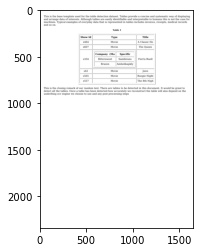

In [59]:
datum = pipeline.datum([7])
label = pipeline.label(datum)
plt.imshow(datum['img'])